In [91]:
from utils import DQN, ReplayBuffer, greedy_action, epsilon_greedy, update_target, loss

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import math
import numpy as np

#import gym
import gymnasium as gym
import matplotlib.pyplot as plt

In [ ]:
NUM_RUNS = 10

hidden_size = 64
num_hidden = 2
learning_rate = 0.0005
replay_buffer_size = 10000
num_episodes = 600
epsilon_start = 1.0
epsilon_end = 0.1
epsilon_decay_rate = 0.995
reward_scaling_factor = 1
batch_size = 256
target_update_frequency_steps = 100

In [93]:
runs_results = []

epsilon = epsilon_start
env = gym.make('CartPole-v1')
for run in range(NUM_RUNS):
    print(f"Starting run {run+1} of {NUM_RUNS}")
    layers = [4] + [hidden_size]*num_hidden + [2]
    policy_net = DQN(layers)
    target_net = DQN(layers)
    update_target(target_net, policy_net)
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    memory = ReplayBuffer(replay_buffer_size)

    steps_done = 0

    episode_durations = []

    for i_episode in range(num_episodes):
        if (i_episode+1) % 50 == 0:
            print("episode ", i_episode+1, "/", 600) #300)

        observation, info = env.reset()
        state = torch.tensor(observation).float()

        done = False
        terminated = False
        t = 0
        while not (done or terminated):

            # Select and perform an action
            action = epsilon_greedy(epsilon, policy_net, state)

            observation, reward, done, terminated, info = env.step(action)
            reward = torch.tensor([reward])/reward_scaling_factor
            action = torch.tensor([action])
            next_state = torch.tensor(observation).reshape(-1).float()

            memory.push([state, action, next_state, reward, torch.tensor([done])])

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            if not len(memory.buffer) < batch_size:
                transitions = memory.sample(batch_size)
                state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                # Compute loss
                mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                # Optimize the model
                optimizer.zero_grad()
                mse_loss.backward()
                optimizer.step()
            
            if done or terminated:
                episode_durations.append(t + 1)
            t += 1
            steps_done += 1
            # Update the target network, copying all weights and biases in DQN
            if steps_done % target_update_frequency_steps == 0: 
                update_target(target_net, policy_net)
    
        epsilon = max(0.1, epsilon_start * (epsilon_decay_rate ** i_episode))

    runs_results.append(episode_durations)
print('Complete')
# Save the trained policy network
torch.save(policy_net.state_dict(), "trained_policy_net.pth")

Starting run 1 of 10
episode  50 / 600
episode  100 / 600
episode  150 / 600
episode  200 / 600
episode  250 / 600
episode  300 / 600
episode  350 / 600
episode  400 / 600
episode  450 / 600
episode  500 / 600
episode  550 / 600
episode  600 / 600
Starting run 2 of 10
episode  50 / 600
episode  100 / 600
episode  150 / 600
episode  200 / 600
episode  250 / 600
episode  300 / 600
episode  350 / 600
episode  400 / 600
episode  450 / 600
episode  500 / 600
episode  550 / 600
episode  600 / 600
Starting run 3 of 10
episode  50 / 600
episode  100 / 600
episode  150 / 600
episode  200 / 600
episode  250 / 600
episode  300 / 600
episode  350 / 600
episode  400 / 600
episode  450 / 600
episode  500 / 600
episode  550 / 600
episode  600 / 600
Starting run 4 of 10
episode  50 / 600
episode  100 / 600
episode  150 / 600
episode  200 / 600
episode  250 / 600
episode  300 / 600
episode  350 / 600
episode  400 / 600
episode  450 / 600
episode  500 / 600
episode  550 / 600
episode  600 / 600
Starting

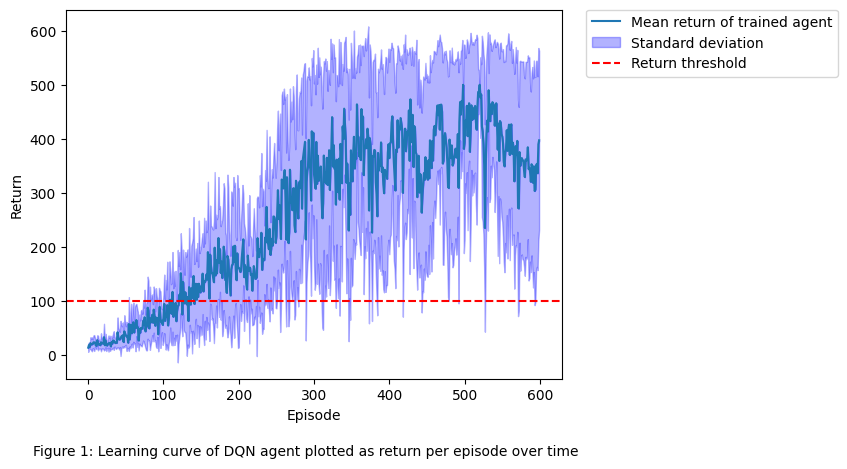

In [94]:
# Plotting the learning curve
# Placeholder plot, you are free to modify it

num_episodes = len(runs_results[0])

results = torch.tensor(runs_results)
means = results.float().mean(0)
stds = results.float().std(0)

plt.plot(torch.arange(num_episodes), means,label="Mean return of trained agent")
plt.ylabel("Return")
plt.xlabel("Episode") 
plt.fill_between(np.arange(num_episodes), means, means+stds, alpha=0.3, color='b',label="Standard deviation")
plt.fill_between(np.arange(num_episodes), means, means-stds, alpha=0.3, color='b')
plt.axhline(y=100, color='r', linestyle='--',label="Return threshold")
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10, borderaxespad=0.)
plt.figtext(0.5, -0.05, "Figure 1: Learning curve of DQN agent plotted as return per episode over time", 
            wrap=True, horizontalalignment='center', fontsize=10)
plt.show()

C:\Users\HUAZHEN XU\AppData\Local\Temp\ipykernel_15676\1381845815.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy_net.load_state_dict(torch.load("trained_policy_

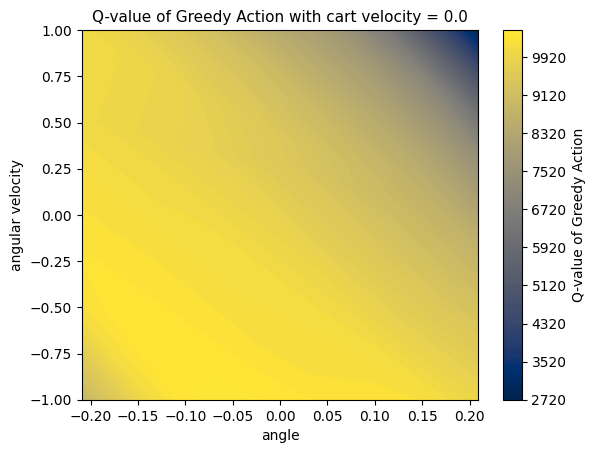

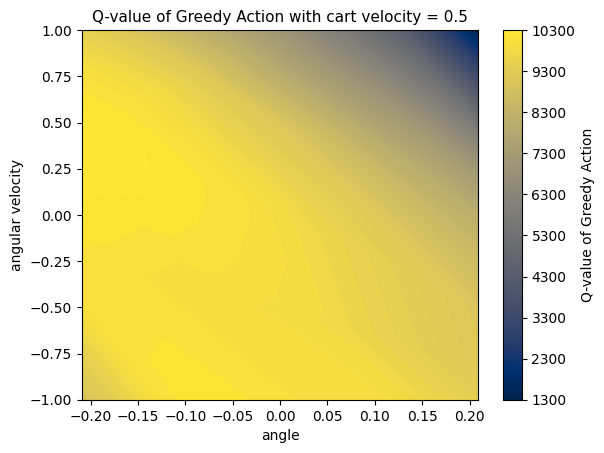

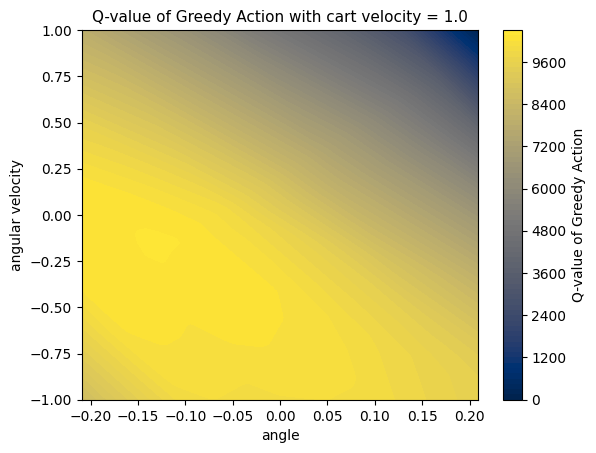

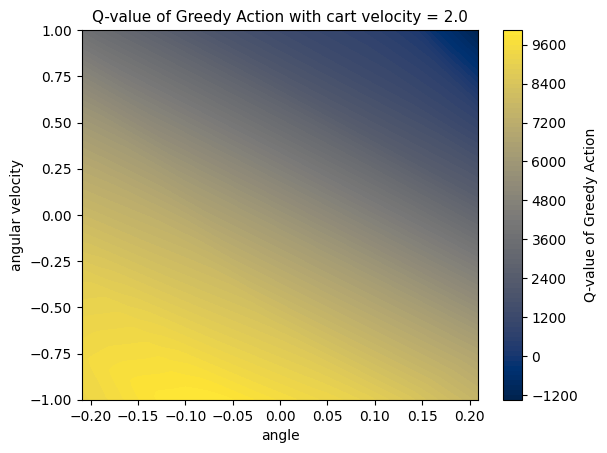

In [97]:
# Visualising the greedy Q-values for a stationary cart in the middle of the track
# 2D plot showing policy as a function of pole angle and angular velocity (omega)

# This plots the policy and Q values according to the network currently
# stored in the variable "policy_net"

# All visualisations provided here are placeholders and you can freely modify these plots and code

# Make sure to include appropriate labels and/or legends when presenting your plot

policy_net = DQN([4,64,64,2])   # randomly initialised, replace with your trained DQN

# Load the trained weights into the policy network
policy_net.load_state_dict(torch.load("trained_policy_net.pth"))

# Set the network to evaluation mode
policy_net.eval()

q = True    # whether q values or greedy policy is visualised

angle_range = .2094 # you may modify this range
omega_range = 1     # you may modify this range

angle_samples = 100
omega_samples = 100
angles = torch.linspace(angle_range, -angle_range, angle_samples)
omegas = torch.linspace(-omega_range, omega_range, omega_samples)

greedy_q_array = torch.zeros((angle_samples, omega_samples))
policy_array = torch.zeros((angle_samples, omega_samples))
for velocity in [0.,0.5,1.,2.]:    
    for i, angle in enumerate(angles):
        for j, omega in enumerate(omegas):
            state = torch.tensor([0., velocity, angle, omega])
            with torch.no_grad():
                q_vals = policy_net(state)
                greedy_action = q_vals.argmax()
                greedy_q_array[i, j] = q_vals[greedy_action]
                policy_array[i, j] = greedy_action
    
    
    if q:
        plt.contourf(angles, omegas, greedy_q_array.T, cmap='cividis', levels=100)
        plt.colorbar(label="Q-value of Greedy Action")
        plt.title(f"Q-value of Greedy Action with cart velocity = {velocity}", fontsize=11)
    else:
        plt.contourf(angles, omegas, policy_array.T, cmap='cividis')
        plt.colorbar(label="Greedy Action (blue: Left, yellow: Right)", orientation="horizontal")
        plt.title(f"Greedy Action with cart velocity = {velocity}", fontsize=11)
    plt.xlabel("angle")
    plt.ylabel("angular velocity")

    plt.show()